In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rcParams['axes.facecolor']='white'
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
# Prepare lists to store the flattened images and labels
flattened_images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        original_dimensions = (img.size[1], img.size[0])
        flattened_img = np.array(img).flatten()
        flattened_images.append(flattened_img)
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(flattened_images)
label_array = np.array(labels)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)
print("Original image dimensions:", original_dimensions)

Image matrix shape: (2414, 32256)
Labels array shape: (2414,)
Original image dimensions: (192, 168)


In [60]:
#Alternatively, read from the pickle
import pickle
with open('young_matrix.pkl', 'rb') as file:
    image_matrix = pickle.load(file)

with open('young_labels.pkl', 'rb') as file:
    label_array = np.array(pickle.load(file))

original_dimensions = (144, 104)

In [61]:
# Unique classes in the dataset
unique_classes = np.unique(labels)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = image_matrix[train_indices]
X_test = image_matrix[test_indices]
y_train = label_array[train_indices]
y_test = label_array[test_indices]

In [62]:
#First apply PCA to reduce the dimensionality of the dataset
num_pca_components = X_train.shape[0] // 5
pca = PCA(n_components=num_pca_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
n_classes = len(np.unique(y_train))

#First find mean vector of each class
mean_vectors = []
for cls in unique_classes:
    cls_indices = np.where(y_train == cls)[0]
    cls_mean = np.mean(X_train_pca[cls_indices], axis=0)
    mean_vectors.append(cls_mean)

#Now find the within-class scatter matrix
Sw = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(y_train == cls)[0]
    cls_scatter = np.zeros((num_pca_components, num_pca_components))
    for idx in cls_indices:
        row = X_train_pca[idx].reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        cls_scatter += np.dot((row - mean_vec), (row - mean_vec).T)
    Sw += cls_scatter

#Now find the between-class scatter matrix
overall_mean = np.mean(X_train_pca, axis=0)
Sb = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(y_train == cls)[0]
    n_cls = len(cls_indices)
    mean_vec = mean_vec.reshape(-1, 1)
    overall_mean = overall_mean.reshape(-1, 1)
    Sb += n_cls * np.dot((mean_vec - overall_mean), (mean_vec - overall_mean).T)

#Now find Fisherfaces as the eigenvectors corresponding to the positive eigenvalues of Sw^(-1)Sb such that eigenvalues are sorted in descending order
eigenvalues, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
#Flip the eigenvectors and eigenvalues to sort them in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

valid_eigenvectors = eigenvectors[:, np.where(eigenvalues > 0)[0]]
valid_eigenvalues = eigenvalues[np.where(eigenvalues > 0)]
invalid_eigenvectors = eigenvectors[:, np.where(eigenvalues <= 0)[0]]
invalid_eigenvalues = eigenvalues[np.where(eigenvalues <= 0)]

fisherfaces = np.dot(valid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))
invalid_fisherfaces = np.dot(invalid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))

In [5]:
print("Number of valid Fisherfaces:", fisherfaces.shape[0])
print("Number of invalid Fisherfaces:", invalid_fisherfaces.shape[0])

Number of valid Fisherfaces: 37
Number of invalid Fisherfaces: 324


In [63]:
def apply_fisherfaces(X, y, num_pca_components, num_lda_components):  
    pca = PCA(n_components=num_pca_components)
    X_pca = pca.fit_transform(X)
    
    lda = LDA(n_components=num_lda_components, solver='eigen')
    X_fisher = lda.fit_transform(X_pca, y)

    return X_fisher, pca, lda

In [64]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [65]:
logistic_classifier = LogisticRegression(random_state = 42, C = 0.005, max_iter = 500)
svm_classifier = SVC(kernel = 'linear', random_state = 42, C = 0.001, max_iter = 500)

In [66]:
component_list = [1]
logistic_accuracies = []
svm_accuracies = []
for num_components in component_list:
    X_train_fisher, pca, lda = apply_fisherfaces(X_train, y_train, num_pca_components = num_pca_components, num_lda_components = num_components)
    X_test_fisher = lda.transform(pca.transform(X_test))
    logistic_accuracy = evaluate_model(logistic_classifier, X_train_fisher, y_train, X_test_fisher, y_test)
    logistic_accuracies.append(logistic_accuracy)
    svm_accuracy = evaluate_model(svm_classifier, X_train_fisher, y_train, X_test_fisher, y_test)
    svm_accuracies.append(svm_accuracy)

C:\Users\korki\anaconda3\envs\mnlp\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


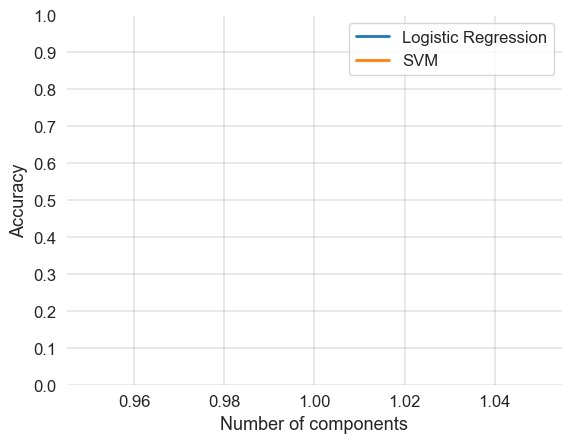

In [30]:
# Using subplots
plt.plot(component_list, logistic_accuracies, label = 'Logistic Regression', linewidth = 2)
plt.plot(component_list, svm_accuracies, label = 'SVM', linewidth = 2)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.grid(color='black', linewidth=0.25, alpha=0.5)
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.show()

In [67]:
print("Logistic Regression accuracy:", logistic_accuracies)
print("SVM accuracy:", svm_accuracies)

Logistic Regression accuracy: [0.686]
SVM accuracy: [0.6253333333333333]


In [14]:
#pickle the accuracies
import pickle
with open('fisher_log_accuracies.pkl', 'wb') as file:
    pickle.dump(logistic_accuracies, file)
    
with open('fisher_svm_accuracies.pkl', 'wb') as file:
    pickle.dump(svm_accuracies, file)